In [ ]:
#Memory Test Data
import pandas as pd
df_Stimuli=pd.read_csv("/content/item_properties.csv")

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "meta-llama/Llama-3.1-8B-Instruct"


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

# Single Recognition Block

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json



li_SR = []
li_Target_words=[]
li_Foil_Words=[]


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response: str):

    match = re.search(r"A:\s*([^\n]*)", response)
    if match:

        word_list = match.group(1).split(",")
        return [word.strip() for word in word_list if word.strip()]
    else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=40,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Provide output of orignal memorized words separated by comma and nothing else.

    {question}
    """
    return prompt



for i in range(30):

    study_phase = df_Stimuli.sample(10)
    study_words = study_phase['Word'].tolist()
    random.shuffle(study_words)
    li_Target_words.extend(study_words)

    foil_size = 10
    all_words = set(df_Stimuli['Word'].tolist())
    foil_words = random.sample(list(all_words - set(study_words)), foil_size)
    li_Foil_Words.extend(foil_words)

    test_phase_words = study_words + foil_words
    random.shuffle(test_phase_words)



    question = f"""Task: Memorize the words in this list : {', '.join(study_words)}.
                   Q: Now, from the given list of words, recall the original words that you memorized:   {', '.join(test_phase_words)}\nA:"""

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    li_SR.extend(words)
    #print(response)

# Processing Model Results for Single Recognition Block

In [ ]:
df_SR = pd.DataFrame({
    "Target": li_Target_words,
    "Foil": li_Foil_Words
})

df_SR["IsCorrect"] = df_SR.apply(
    lambda row: 1 if row["Target"] in li_SR else (
        2 if row["Foil"] in li_SR else 0
    ), axis=1
)

df_SR["ModelPredicted"] = df_SR.apply(
    lambda row: row["Target"] if row["Target"] in li_SR else (
        row["Foil"] if row["Foil"] in li_SR else None
    ), axis=1
)

In [ ]:
df_SR

In [ ]:
correct_Target_SR = len(df_SR[df_SR["IsCorrect"] == 1])
correct_Foils_SR = len(df_SR[df_SR["IsCorrect"] == 2])

total = len(df_SR)

RP_Targets_SR = correct_Target_SR / total
RP_Foils_SR = correct_Foils_SR / total


summary_SR = {

    "RP_Targets": [RP_Targets_SR],
    "RP_Foils": [RP_Foils_SR]
}
summary_df_SR = pd.DataFrame(summary_SR)

In [ ]:
summary_df_SR

# Cued Recall Block

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json



li_CR = []
li_word_pairs=[]



tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response):

    match = re.search(r"A:\s*(.*)", response, re.DOTALL)
    if match:
        answer_section = match.group(1)

        word_pairs = re.findall(r"\b\w+-\w+\b", answer_section)
        return word_pairs
    else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Provide output of orignal memorized word pair and nothing else.

    {question}
    """
    return prompt



for i in range(30):

    study_size_CR = 20
    study_words_CR1 = random.sample(df_Stimuli['Word'].tolist(), study_size_CR)
    study_words_CR2 = random.sample(df_Stimuli['Word'].tolist(), study_size_CR)
    study_pairs_CR = [f"{w1}-{w2}" for w1, w2 in zip(study_words_CR1, study_words_CR2)]
    li_word_pairs.extend(study_pairs_CR)

    cues = [pair.split('-')[0] for pair in study_pairs_CR]
    random.shuffle(cues)


    question = f"""Task: Memorize the word pairs in this list : {', '.join(study_pairs_CR)}.
                   Q: Now, from the given list of cue words, recall the corresponding another word that you memorized in pair:   {', '.join(cues)}\nA:"""

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    li_CR.extend(words)
    #print(response)
    #print(words)

# Processing Model Results for Cued Recall

In [ ]:
df_CR = pd.DataFrame({
    "Target": li_word_pairs
})

df_CR["IsCorrect"] = df_CR.apply(
    lambda row: 1 if row["Target"] in li_CR else  0, axis=1)

df_CR["ModelPredicted"] = df_CR.apply(
    lambda row: row["Target"] if row["Target"] in li_CR else None, axis=1
)

In [ ]:
df_CR

In [ ]:
correct_Target_CR = len(df_CR[df_CR["IsCorrect"] == 1])
correct_Foils_CR = len(df_CR[df_CR["IsCorrect"] == 0])

total = len(df_CR)

RP_Targets_CR = correct_Target_CR / total
RP_Foils_CR = correct_Foils_CR / total


summary_CR= {

    "RP_Targets": [RP_Targets_CR],
    "RP_Foils": [RP_Foils_CR]
}
summary_df_CR = pd.DataFrame(summary_CR)

In [ ]:
summary_df_CR

# Associative Recognition Block

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json

study_words_1 = random.sample(df_Stimuli['Word'].tolist(), 10)
study_words_2 = random.sample(df_Stimuli['Word'].tolist(), 10)
study_pairs = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
random.shuffle(study_pairs)

random.shuffle(study_words_1)
random.shuffle(study_words_2)
rearranged_pair = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
random.shuffle(rearranged_pair)

li_AR_IntactPair = []
li_AR_RearrangedPair=[]
li_AR=[]


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response):

     match = re.search(r"A:\s*([\s\S]+)", response)
     if match:

        raw_text = match.group(1).replace("\n", " ")

        word_pairs = re.findall(r"\b[\w-]+-[\w-]+\b", raw_text)
        return word_pairs
     else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Provide output of orignal memorized word pair and nothing else.

    {question}
    """
    return prompt



for i in range(30):

    study_words_1 = random.sample(df_Stimuli['Word'].tolist(), 10)
    study_words_2 = random.sample(df_Stimuli['Word'].tolist(), 10)
    study_pairs = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
    random.shuffle(study_pairs)
    li_AR_IntactPair.extend(study_pairs)

    random.shuffle(study_words_1)
    random.shuffle(study_words_2)
    rearranged_pair = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
    random.shuffle(rearranged_pair)
    li_AR_RearrangedPair.extend(rearranged_pair)


    question = f"""Task: Memorize the Word Pair Association in this list : {', '.join(study_pairs)}.
                   Q: Now, from the given list of Rearranged words, recall the original word pairs:   {', '.join(rearranged_pair)}\nA:"""

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    li_AR.extend(words)
    #print(response)
    #print(words)

# Processing Model Results for Associative Recognition

In [ ]:
df_AR = pd.DataFrame({
    "IntactPairs": li_AR_IntactPair,
    "RearrangedPairs": li_AR_RearrangedPair
})

#df_AR["ModelPrediction"] = li_AR  # Add the li_AR list as a new column


df_AR["IsCorrect"] = df_AR.apply(
    lambda row: 1 if row["IntactPairs"] in li_AR else (
        2 if row["RearrangedPairs"] in li_AR else 0
    ), axis=1)

df_AR["ModelPredicted"] = df_AR.apply(
    lambda row: row["IntactPairs"] if row["IntactPairs"] in li_AR else
                (row["RearrangedPairs"] if row["RearrangedPairs"] in li_AR else None),
    axis=1
)


In [ ]:
df_AR

In [ ]:
correct_Target_AR = len(df_AR[df_AR["IsCorrect"] == 1])
correct_Foils_AR = len(df_AR[df_AR["IsCorrect"] == 2])

total = len(df_AR)

RP_Targets_AR = correct_Target_AR / total
RP_Foils_AR = correct_Foils_AR / total


summary_AR = {

    "RP_Targets": [RP_Targets_AR],
    "RP_Foils": [RP_Foils_AR]
}
summary_df_AR = pd.DataFrame(summary_AR)

In [ ]:
Summary_df_AR

# Free Recall

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json

li_FR=[]

recall_task_words = random.sample(combined_words, 10)
recall_task_words


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

def extract_words_from_response(response):

   match = re.search(r"A:\s*([\s\S]+?)(?=\n\n|\Z)", response)
   if match:

        raw_text = match.group(1).replace("\n", " ")

        words = re.findall(r"\b[A-Z]+\b", raw_text)
        return words
   else:
        return []


def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=120,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def structured_prompt(question):
    prompt = f"""
    Recall the words separated by comma.

    {question}
    """
    return prompt



for i in range(1):



    question = f"""Task: Memorize the Words in this list : {', '.join(recall_task_words)}.
                   Q: Now, from the given list, recall the words that you memorized. \nA:"""

    prompt = structured_prompt(question)

    response = generate_response(prompt)
    words = extract_words_from_response(response)
    #print("Raw Response:", response)
    #print(words)
    #i_FR.extend(words)
    #print(response)
    #print(words)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=120) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


# Final Block (In Sequence)

In [ ]:
#Functions SR Block
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import re
import json



def structured_prompt_SR(question):
    prompt = f"""
    Provide then provide output of orignal memorized words separated by comma and nothing else.

    {question_SR}
    """
    return prompt

def extract_words_from_response_SR(response: str):

    match = re.search(r"A:\s*([^\n]*)", response)
    if match:

        word_list = match.group(1).split(",")
        return [word.strip() for word in word_list if word.strip()]
    else:
        return []

li_SR = []
li_Target_words_SR=[]
li_Foil_Words_SR=[]

In [ ]:
#Function Block Cued Recall
li_CR = []
li_word_pairs_CR=[]


def extract_words_from_response_CR(response):

    match = re.search(r"A:\s*(.*)", response, re.DOTALL)
    if match:
        answer_section = match.group(1)

        word_pairs = re.findall(r"\b\w+-\w+\b", answer_section)
        return word_pairs
    else:
        return []

def structured_prompt_CR(question):
    prompt = f"""
    Provide output of orignal memorized word pair and nothing else.

    {question_CR}
    """
    return prompt

In [ ]:
## Associative Recognition Function Block
li_AR_IntactPair = []
li_AR_RearrangedPair=[]
li_AR=[]


def extract_words_from_response_AR(response):

     match = re.search(r"A:\s*([\s\S]+)", response)
     if match:

        raw_text = match.group(1).replace("\n", " ")

        word_pairs = re.findall(r"\b[\w-]+-[\w-]+\b", raw_text)
        return word_pairs
     else:
        return []


def structured_prompt_AR(question):
    prompt = f"""
    Provide output of orignal memorized word pair and nothing else.

    {question_AR}
    """
    return prompt

In [ ]:
## Lexical Decision Function Block
import random
import math
combined_words = df_Stimuli['Word'].unique().tolist()
combined_words_LD_int = pd.concat([df_Stimuli['Word'], df_Stimuli['Pseudoword']]).unique().tolist()
cleaned_list = [value for value in combined_words_LD_int if not (isinstance(value, float) and math.isnan(value))]
combined_words_LD=cleaned_list
random.shuffle(combined_words_LD)

li_LD = []
Lexical_words=[]



def extract_words_from_response_LD(response: str):

    match = re.search(r"A:\s*([^\n]*)", response)
    if match:

        word_list = match.group(1).split(",")
        return [word.strip() for word in word_list if word.strip()]
    else:
        return []


def structured_prompt_LD(question):
    prompt = f"""
    Provide output of valid words separated by comma.

    {question_LD}
    """
    return prompt

In [ ]:
## Distractor Block

def structured_prompt_DIS(question):
    prompt = f"""
    Provide sum of all the digits in the list.

    {question_distractor}
    """
    return prompt


In [ ]:
## Free Recall

li_FR=[]
word_li_FR=[]

def extract_words_from_response_FR(response):

   match = re.search(r"A:\s*([\s\S]+?)(?=\n\n|\Z)", response)
   if match:
        #
        raw_text = match.group(1).replace("\n", " ")

        words = re.findall(r"\b[A-Z]+\b", raw_text)
        return words
   else:
        return []


def structured_prompt_FR(question):
    prompt = f"""
    Recall the words separated by comma.

    {question_FR}
    """
    return prompt

In [ ]:
import random
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct").cuda()

## Single Recognition
def generate_response_SR(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=70,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

##Cued Recall
def generate_response_CR(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

##Associative Recognition
def generate_response_AR(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=200,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


##Lexical Decision
def generate_response_LD(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=40,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def generate_response_distractor(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=40,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=2,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)



def generate_response_FR(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs.input_ids,
        max_length=100,
        temperature=0,
        attention_mask=inputs["attention_mask"],
        top_p=1.0,
        max_new_tokens=120,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


for i in range(150):

  #SR Block
  study_phase_SR = df_Stimuli.sample(10)
  study_words_SR = study_phase_SR['Word'].tolist()
  random.shuffle(study_words_SR)
  li_Target_words_SR.extend(study_words_SR)

  foil_size_SR = 10
  all_words_SR = set(df_Stimuli['Word'].tolist())
  foil_words_SR = random.sample(list(all_words_SR - set(study_words_SR)), foil_size_SR)
  li_Foil_Words_SR.extend(foil_words_SR)

  test_phase_words_SR = study_words_SR + foil_words_SR
  random.shuffle(test_phase_words_SR)

  random_digits = [random.randint(1, 9) for i in range(15)]

  question_SR = f"""Task1: Memorize the words in this list : {', '.join(study_words_SR)}.
                    Q: Now, from the given list of words, recall the original words that you memorized:   {', '.join(test_phase_words_SR)}\nA:"""

  prompt_SR = structured_prompt_SR(question_SR)

  response_SR = generate_response_SR(prompt_SR)
  words_SR = extract_words_from_response_SR(response_SR)
  #print("Raw Response:", response)
  #print(words)
  li_SR.extend(words_SR)
  #print(response)


  ## Associative Recognition Block

  study_words_1 = random.sample(df_Stimuli['Word'].tolist(), 10)
  study_words_2 = random.sample(df_Stimuli['Word'].tolist(), 10)
  study_pairs_AR = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
  random.shuffle(study_pairs_AR)
  li_AR_IntactPair.extend(study_pairs_AR)

  random.shuffle(study_words_1)
  random.shuffle(study_words_2)
  rearranged_pair = [f"{w1}-{w2}" for w1, w2 in zip(study_words_1, study_words_2)]
  random.shuffle(rearranged_pair)
  li_AR_RearrangedPair.extend(rearranged_pair)

  question_AR = f"""Task: Memorize the Word Pair Association in this list : {', '.join(study_pairs_AR)}.
                   Q: Now, from the given list of Rearranged words, recall the original word pairs:   {', '.join(rearranged_pair)}\nA:"""

  prompt_AR = structured_prompt_AR(question_AR)

  response_AR = generate_response_AR(prompt_AR)
  words_AR = extract_words_from_response_AR(response_AR)
  li_AR.extend(words_AR)



  ## Cued Recall Block

  study_size_CR = 20
  study_words_CR1 = random.sample(df_Stimuli['Word'].tolist(), study_size_CR)
  study_words_CR2 = random.sample(df_Stimuli['Word'].tolist(), study_size_CR)
  study_pairs_CR = [f"{w1}-{w2}" for w1, w2 in zip(study_words_CR1, study_words_CR2)]
  li_word_pairs_CR.extend(study_pairs_CR)

  cues = [pair.split('-')[0] for pair in study_pairs_CR]
  random.shuffle(cues)

  question_CR = f"""Task: Memorize the word pairs in this list : {', '.join(study_pairs_CR)}.
                   Q: Now, from the given list of cue words, recall the corresponding another word that you memorized in pair:   {', '.join(cues)}\nA:"""

  prompt_CR = structured_prompt_CR(question_CR)

  response_CR = generate_response_CR(prompt_CR)
  words_CR = extract_words_from_response_CR(response_CR)

  li_CR.extend(words_CR)


  ## Free Recall

  recall_task_words = random.sample(combined_words, 10)
  random.shuffle(recall_task_words)
  word_li_FR.extend(recall_task_words)

  question_FR = f"""Task: Memorize the Words in this list : {', '.join(recall_task_words)}.
                   Q: Now, from the given list, recall the words that you memorized. \nA:"""

  prompt_FR = structured_prompt_FR(question_FR)

  response_FR = generate_response_FR(prompt_FR)
  words_FR = extract_words_from_response_FR(response_FR)
  li_FR.extend(words_FR)




  ##Lexical Decision Block



  Lexical_task_words = random.sample(combined_words_LD, 10)
  Lexical_words.extend(Lexical_task_words)

  question_LD = f"Q: What are the valid English Words from the given list: {', '.join(Lexical_task_words)} ?\nA:"

  prompt_LD = structured_prompt_LD(question_LD)

  response_LD = generate_response_LD(prompt_LD)
  words_LD = extract_words_from_response_LD(response_LD)
  li_LD.extend(words_LD)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=70) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Both `max_new_tokens` (=200) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:128009 f

Single Recognition (Final Results)

In [ ]:
df_SR = pd.DataFrame({
    "Target": li_Target_words_SR,
    "Foil": li_Foil_Words_SR
})

df_SR["IsCorrect"] = df_SR.apply(
    lambda row: 1 if row["Target"] in li_SR else (
        2 if row["Foil"] in li_SR else 0
    ), axis=1
)

df_SR["ModelPredicted"] = df_SR.apply(
    lambda row: row["Target"] if row["Target"] in li_SR else (
        row["Foil"] if row["Foil"] in li_SR else None
    ), axis=1
)

correct_Target_SR = len(df_SR[df_SR["IsCorrect"] == 1])
correct_Foils_SR = len(df_SR[df_SR["IsCorrect"] == 2])

total = len(df_SR)

RP_Targets_SR = correct_Target_SR / total
RP_Foils_SR = correct_Foils_SR / total


summary_SR = {

    "RP_Targets": [RP_Targets_SR],
    "RP_Foils": [RP_Foils_SR]
}
summary_df_SR = pd.DataFrame(summary_SR)

In [ ]:
df_SR

,Target,Foil,IsCorrect,ModelPredicted
0,SIZES,MARKS,1,SIZES
1,GOAL,COMPUTER,1,GOAL
2,DOLLAR,SENATE,1,DOLLAR
3,HELPFUL,CRYING,1,HELPFUL
4,SURVIVE,MISTAKE,1,SURVIVE
...,...,...,...,...
1495,PROTECTED,EXACT,1,PROTECTED
1496,AGES,LINED,1,AGES
1497,LISTENED,BARN,1,LISTENED
1498,ISLANDS,POLICIES,1,ISLANDS


In [ ]:
summary_df_SR

,RP_Targets,RP_Foils
0,0.996,0.004


Cued Recall Final Block

In [ ]:
df_CR = pd.DataFrame({
    "Target": li_word_pairs_CR
})

df_CR["IsCorrect"] = df_CR.apply(
    lambda row: 1 if row["Target"] in li_CR else  0, axis=1)

df_CR["ModelPredicted"] = df_CR.apply(
    lambda row: row["Target"] if row["Target"] in li_CR else None, axis=1
)

correct_Target_CR = len(df_CR[df_CR["IsCorrect"] == 1])
correct_Foils_CR = len(df_CR[df_CR["IsCorrect"] == 0])

total = len(df_CR)

RP_Targets_CR = correct_Target_CR / total
RP_Foils_CR = correct_Foils_CR / total


summary_CR= {

    "RP_Targets": [RP_Targets_CR],
    "RP_Foils": [RP_Foils_CR]
}
summary_df_CR = pd.DataFrame(summary_CR)

In [ ]:
df_CR

,Target,IsCorrect,ModelPredicted
0,BIRTHDAY-FUNNY,1,BIRTHDAY-FUNNY
1,ASPECTS-SURFACES,1,ASPECTS-SURFACES
2,PORCH-INSTITUTIONS,1,PORCH-INSTITUTIONS
3,EATEN-PROUD,1,EATEN-PROUD
4,EXCITEMENT-SLAVERY,1,EXCITEMENT-SLAVERY
...,...,...,...
2995,YELLED-COPY,1,YELLED-COPY
2996,SATISFACTION-COMMUNICATE,1,SATISFACTION-COMMUNICATE
2997,PATIENT-NODDED,1,PATIENT-NODDED
2998,WARS-DRINKING,1,WARS-DRINKING


In [ ]:
summary_df_CR

,RP_Targets,RP_Foils
0,0.868,0.132


Associative Recog

In [ ]:
df_AR = pd.DataFrame({
    "IntactPairs": li_AR_IntactPair,
    "RearrangedPairs": li_AR_RearrangedPair
})

#df_AR["ModelPrediction"] = li_AR  # Add the li_AR list as a new column


df_AR["IsCorrect"] = df_AR.apply(
    lambda row: 1 if row["IntactPairs"] in li_AR else (
        2 if row["RearrangedPairs"] in li_AR else 0
    ), axis=1)

df_AR["ModelPredicted"] = df_AR.apply(
    lambda row: row["IntactPairs"] if row["IntactPairs"] in li_AR else
                (row["RearrangedPairs"] if row["RearrangedPairs"] in li_AR else None),
    axis=1
)

correct_Target_AR = len(df_AR[df_AR["IsCorrect"] == 1])
correct_Foils_AR = len(df_AR[df_AR["IsCorrect"] == 2])

total = len(df_AR)

RP_Targets_AR = correct_Target_AR / total
RP_Foils_AR = correct_Foils_AR / total


summary_AR = {

    "RP_Targets": [RP_Targets_AR],
    "RP_Foils": [RP_Foils_AR]
}
summary_df_AR = pd.DataFrame(summary_AR)


In [ ]:
df_AR

,IntactPairs,RearrangedPairs,IsCorrect,ModelPredicted
0,FOLLOWS-SHARPLY,FOLLOWS-SHARPLY,1,FOLLOWS-SHARPLY
1,FURNITURE-SWEET,RELIEF-FRIENDLY,1,FURNITURE-SWEET
2,HUNT-MEMORY,HUNT-FUEL,1,HUNT-MEMORY
3,TRAVELED-FINGER,DEPRESSION-BRIEF,1,TRAVELED-FINGER
4,CLASSROOM-BRIEF,HARM-ARRANGED,1,CLASSROOM-BRIEF
...,...,...,...,...
1495,BREATHE-LINED,BUYING-CLAY,2,BUYING-CLAY
1496,DEVICE-CLAY,BREATHE-CONSTANTLY,2,BREATHE-CONSTANTLY
1497,SIGNAL-FASHION,SIGNAL-HOUSEHOLD,2,SIGNAL-HOUSEHOLD
1498,NIGHTS-SEVERE,OPERATIONS-FASHION,2,OPERATIONS-FASHION


In [ ]:
summary_df_AR

,RP_Targets,RP_Foils
0,0.75,0.200667


In [ ]:

main_df=df_Stimuli[['Word','Pseudoword']]

main_df["IsCorrect"] = main_df.apply(
    lambda row: 1 if row["Word"] in li_LD else (
        2 if row["Pseudoword"] in li_LD else 0
    ), axis=1
)

main_df["ModelPredicted"] = main_df.apply(
    lambda row: row["Word"] if row["Word"] in li_LD else (
        row["Pseudoword"] if row["Pseudoword"] in li_LD else None
    ), axis=1
)


correctwords = len(main_df[main_df["IsCorrect"] == 1])
correctPseudowords = len(main_df[main_df["IsCorrect"] == 2])

total = len(main_df)

RP_Targets_LD = correctwords / total
RP_Foils_LD = correctPseudowords / total

# Creating a summary dataframe to display the result
summary_LD = {

    "RP_Targets": [RP_Targets_LD],
    "RP_Foils": [RP_Foils_LD]
}
summary_df_LD = pd.DataFrame(summary_LD)

<ipython-input-31-fe74e69dd044>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df["IsCorrect"] = main_df.apply(
<ipython-input-31-fe74e69dd044>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df["ModelPredicted"] = main_df.apply(


In [ ]:
main_df

,Word,Pseudoword,IsCorrect,ModelPredicted
0,ACCIDENT,ADVIGENT,1,ACCIDENT
1,ACCOUNTS,ACCOANED,0,None
2,ACCURATE,ATRUMATE,0,None
3,ACHIEVE,ACLEAVE,1,ACHIEVE
4,ACID,AXIN,1,ACID
...,...,...,...,...
919,WRITERS,PHOTERS,1,WRITERS
920,YARDS,YTHMS,0,None
921,YELLED,NaN,0,None
922,YOUNGER,YEASTES,1,YOUNGER


In [ ]:
summary_df_LD

,RP_Targets,RP_Foils
0,0.514069,0.127706


In [ ]:
df_FR = pd.DataFrame({
    "Words": word_li_FR
})

df_FR["IsCorrect"] = df_FR.apply(
    lambda row: 1 if row["Words"] in li_FR else 0, axis=1)

df_FR["ModelPredicted"] = df_FR.apply(
    lambda row: row["Words"] if row["Words"] in li_FR  else None,axis=1)

correct_Words_FR = len(df_FR[df_FR["IsCorrect"] == 1])
correct_Foils_FR = len(df_AR[df_FR["IsCorrect"] == 0])

total = len(df_FR)

RP_Words_FR = correct_Words_FR / total
RP_Foils_FR = correct_Foils_FR / total


summary_FR = {

    "RP_Words": [RP_Words_FR],
    "RP_IncorrectWords": [RP_Foils_FR]
}
summary_df_FR = pd.DataFrame(summary_FR)

In [ ]:
df_FR

,Words,IsCorrect,ModelPredicted
0,TRUCK,1,TRUCK
1,TASTE,1,TASTE
2,LATTER,1,LATTER
3,STANDS,1,STANDS
4,MAIL,1,MAIL
...,...,...,...
1495,DAMAGE,1,DAMAGE
1496,COMMUNICATE,1,COMMUNICATE
1497,COLUMN,1,COLUMN
1498,FOCUS,1,FOCUS


In [ ]:
summary_df_FR

,RP_Words,RP_IncorrectWords
0,1.0,0.0


In [ ]:

data = {
    "Task": ["Associative Recognition", "Cued Recall", "Single Recognition", "Lexical Decision","Free Recall"],
    "Targets": [0.75, 0.86, 0.99, 0.51,1.0],
    "Foils": [0.2, 0.13, 0.004, 0.12,0.0]
}

df_final = pd.DataFrame(data)


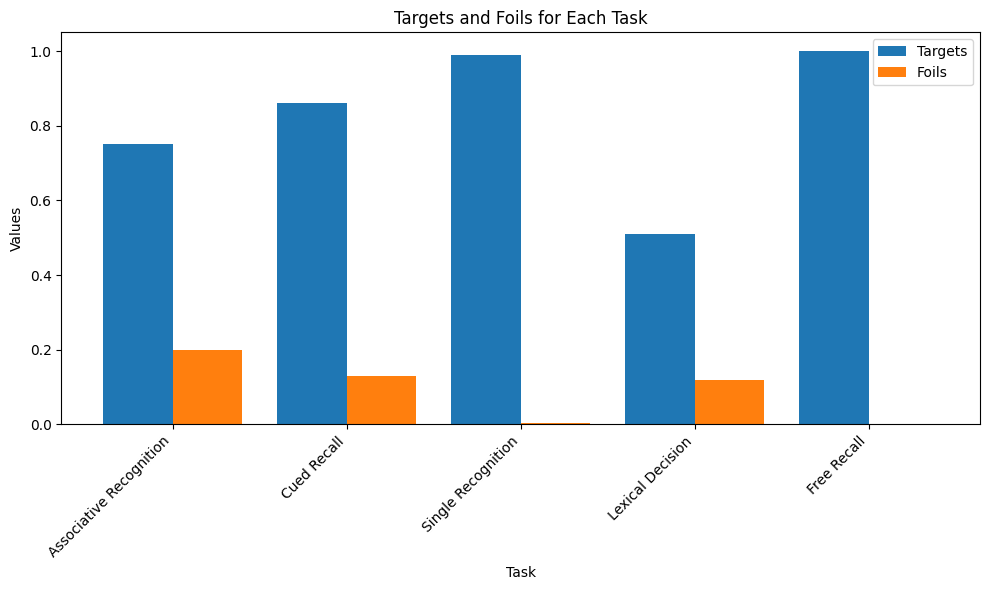

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


x_positions = range(len(df_final))
width = 0.4


plt.bar([x - width/2 for x in x_positions], df_final['Targets'], width=width, label='Targets', align='center')
plt.bar([x + width/2 for x in x_positions], df_final['Foils'], width=width, label='Foils', align='center')


plt.xticks(x_positions, df_final['Task'], rotation=45, ha="right")
plt.xlabel('Task')
plt.ylabel('Values')
plt.title('Targets and Foils for Each Task')
plt.legend()


plt.tight_layout()
plt.show()
